In [1]:
import numpy as np
import pandas as pd
from astropy.io import ascii
import os
import matplotlib.pyplot as plt
import mpl_scatter_density
import seaborn as sns
from sklearn.mixture import GaussianMixture

In [2]:
data = pd.read_csv('Catalogues/NGC5822_4.csv')
data

,RA_ICRS,DE_ICRS,Source,Plx,pmRA,pmDE,Solved,nueff,pscol,RUWE,Gmag,BPmag,RPmag,BP-RP,RV,ELAT,RAJ2000,DEJ2000,Plx_corr
0,226.562522,-56.327802,5880538830781444224,1.1739,-5.756,-5.965,95,NaN,1.4393,1.074,20.220560,NaN,NaN,NaN,NaN,-37.114340,226.562568,-56.327776,1.175188
1,226.540815,-56.317269,5880538895205342848,1.2212,-7.561,-3.855,95,NaN,1.2681,1.020,20.414282,21.562517,19.130104,2.432413,NaN,-37.108574,226.540876,-56.317251,1.178051
2,226.461484,-56.340163,5880539174378845568,1.1586,-8.144,-5.034,95,NaN,1.3523,1.021,19.798546,21.077251,18.408400,2.668852,NaN,-37.145181,226.461549,-56.340141,1.148181
3,226.398085,-56.335706,5880539307516578816,1.2869,-6.523,-7.522,31,1.292,NaN,1.000,18.668010,19.842556,17.508350,2.334206,NaN,-37.153083,226.398137,-56.335672,1.311239
4,226.444467,-56.302930,5880539827213942656,1.1082,-6.309,-5.284,95,NaN,1.2832,1.106,18.936375,20.266830,17.767336,2.499495,NaN,-37.113460,226.444518,-56.302906,1.135459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16715,226.429063,-52.427289,5900301693293744128,1.2397,-5.960,-6.230,95,NaN,1.4962,1.049,20.341524,21.055025,19.403385,1.651640,NaN,-33.466151,226.429106,-52.427262,1.253792
16716,226.412087,-52.414092,5900301762012758016,1.1744,-8.942,-5.031,95,NaN,1.3653,1.054,20.426191,21.275080,19.732313,1.542767,NaN,-33.457089,226.412152,-52.414070,1.162460
16717,226.362904,-52.402953,5900301933811458176,1.1699,-8.500,-5.627,95,NaN,1.4443,1.050,20.185804,20.745785,18.995424,1.750360,NaN,-33.456437,226.362966,-52.402928,1.172566
16718,226.571272,-52.390883,5900302685425379456,1.1524,-5.840,-6.054,95,NaN,1.2739,1.006,19.183874,20.276022,18.106766,2.169256,NaN,-33.403296,226.571315,-52.390856,1.167824


In [3]:
df1 = data[["RAJ2000", "DEJ2000", "pmRA", "pmDE", "BP-RP", "Plx"]].copy()

# Matriz de Correlação das Features

Isso ajuda a identificar se algumas features são redundantes (exemplo: se pmra e pmdec forem altamente correlacionadas, talvez uma delas possa ser descartada).

In [4]:
#correlação de Pearson. já é invariante, não precisa normalizar
corr_matrix = df1.corr()

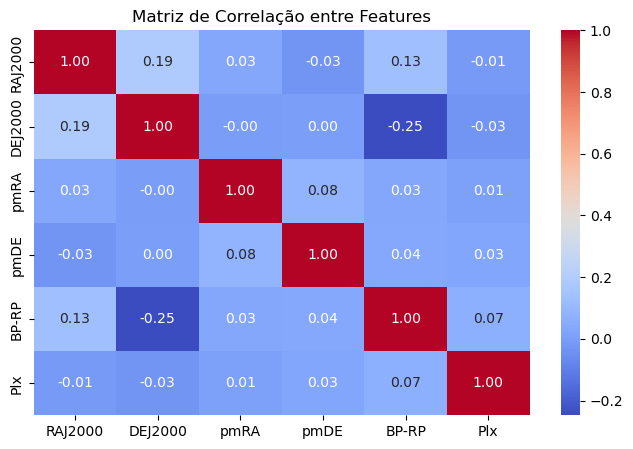

In [5]:
plt.figure(figsize=(8,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação entre Features")
plt.show()

# PCA - Análise das Componentes Principais

Vai nos ajudar a entender:

- Quantas dimensões realmente precisamos?
- Se algumas features contribuem pouco e podem ser descartadas.



## Precisei retirar linhas com valor NaN pra rodar o PCA

Estimei a quantidade de linhas com esses valores pra saber se não estava perdendo muitos objetos.

In [6]:
len(df1)

16720

In [7]:
# Contar quantas linhas têm pelo menos um NaN nas colunas selecionadas
nan_rows = df1.isna().sum(axis=1) > 0
num_nan_rows = nan_rows.sum()

# Exibir o número total de linhas com NaN
print(f"Linhas com pelo menos um NaN: {num_nan_rows}")

Linhas com pelo menos um NaN: 2123


In [8]:
# Verificar a porcentagem de dados ausentes por feature
nan_percentage = df1.isna().mean() * 100
print(f"Porcentagem de NaN por feature:\n{nan_percentage}")

Porcentagem de NaN por feature:
RAJ2000     0.000000
DEJ2000     0.000000
pmRA        0.000000
pmDE        0.000000
BP-RP      12.697368
Plx         0.000000
dtype: float64


In [9]:
# Remover linhas com NaN
df1_clean = df1.dropna()

## Continuando...

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [11]:
X = df1_clean.values

In [12]:
# Normalizar os dados (PCA é sensível à escala!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
# Aplicar PCA
n_components = 6
pca = PCA(n_components=n_components)  # Criamos tantos componentes quanto features temos
pca.fit(X_scaled)

PCA(n_components=6)

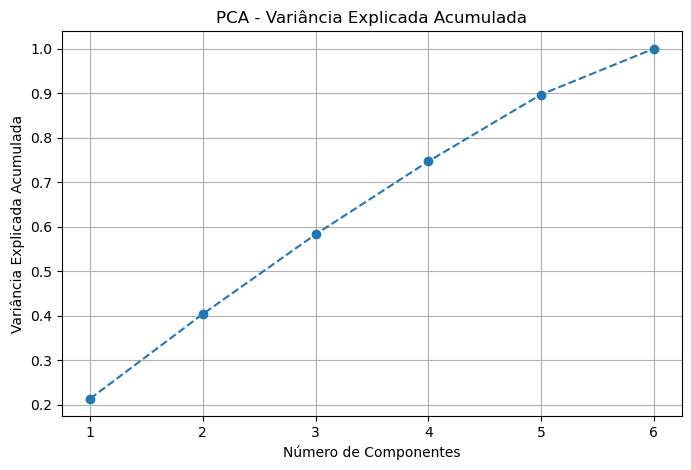

In [14]:
# Plotando a variância explicada acumulada
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel("Número de Componentes")
plt.ylabel("Variância Explicada Acumulada")
plt.title("PCA - Variância Explicada Acumulada")
plt.grid()
plt.show()

Mostra a quantidade acumulada de variância explicada pelos componentes principais, expressa como uma porcentagem. A soma das variâncias de todos os componentes principais será 100%.
Vemos no gráfico que com 5 componentes já atingimos quase 90% de Variância Explicada, o que nos permite representar bem os dados e ainda diminuir as dimensões. A perda de informação será pequena (apenas 10%).


# Random Forest - Análise da Importância das Features

In [21]:
from sklearn.ensemble import RandomForestClassifier

## Rótolus aleatórios

In [22]:
# Gerando rótulos fictícios aleatórios (aqui com 3 classes, mas pode ser ajustado)
np.random.seed(42)
n_samples = len(df1_clean)  # Quantidade de dados
fake_labels = np.random.randint(0, 3, size=n_samples)  # Rótulos aleatórios (0, 1, 2)

# Adicionando ao DataFrame
df1_clean = df1_clean.copy()
df1_clean['Cluster'] = fake_labels
#df1_clean.loc[:, 'Cluster'] = fake_labels

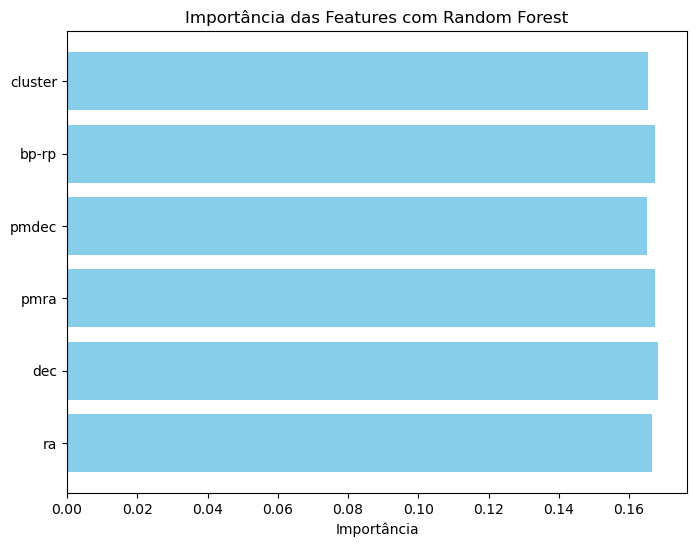

In [23]:
# Definir as features e o target (rótulos fictícios gerados acima)
X = X_scaled  # ou as features originais
y = df1_clean['Cluster']  # rótulos fictícios

# Treinando o modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# features
features = features = ['ra', 'dec', 'pmra', 'pmdec', 'bp-rp', 'cluster'] 
# Importância das features
importances = rf.feature_importances_

# Plotando a importância das features
plt.figure(figsize=(8, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importância')
plt.title('Importância das Features com Random Forest')
plt.show()

## Aplicando clusterização antes de avaliar a importância das features

In [24]:
from sklearn.cluster import KMeans

### Primeiro analisamos a quantidade ideal de clusters

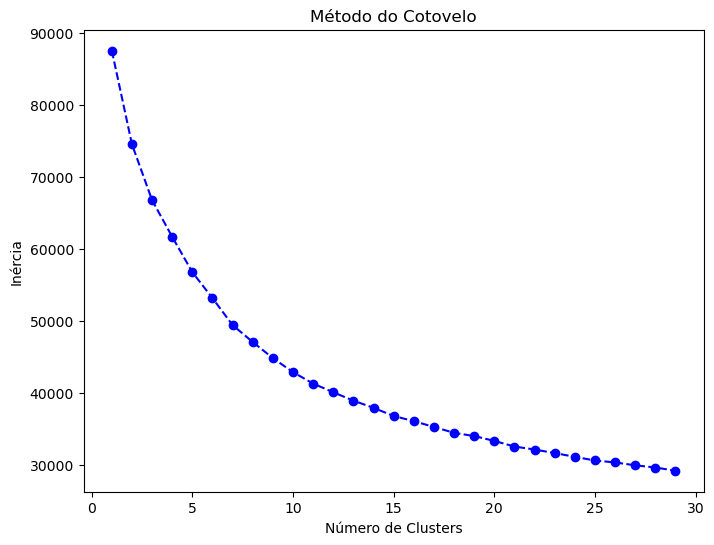

In [25]:
# Testando diferentes números de clusters (de 1 a 10, por exemplo)
inertia = []  # armazena a soma das distâncias quadráticas (inertia)

for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)  # Usando X_scaled ou os dados com PCA se preferir
    inertia.append(kmeans.inertia_)

# Plotando o gráfico do método do cotovelo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 30), inertia, marker='o', linestyle='--', color='b')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')
plt.show()

A inércia (ou "within-cluster sum of squares") é uma métrica usada para avaliar a qualidade de um agrupamento em K-Means.

Ela mede a soma das distâncias quadráticas entre cada ponto de dados e o centroide do seu respectivo cluster. Em outras palavras:

Baixa inércia significa que os pontos dentro de cada cluster estão próximos do centroide (indica que o cluster é bem formado e compacto).
Alta inércia indica que os pontos estão mais espalhados e distantes do centroide, o que sugere clusters mais fracos e menos coesos.

Visualmente a inércia começa a diminuir mais lentamente em k=4-6.

### Agora aplicamos o KMeans

In [26]:
# Aplicando o K-Means com 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)  # Aplicando o K-Means e prevendo os clusters

# Adicionando os clusters ao DataFrame
df1_clean.loc[:, 'Cluster'] = clusters

In [27]:
# Verificando a distribuição dos clusters
print(df1_clean['Cluster'].value_counts())

Cluster
0    3513
4    3144
1    2810
3    2629
2    2501
Name: count, dtype: int64


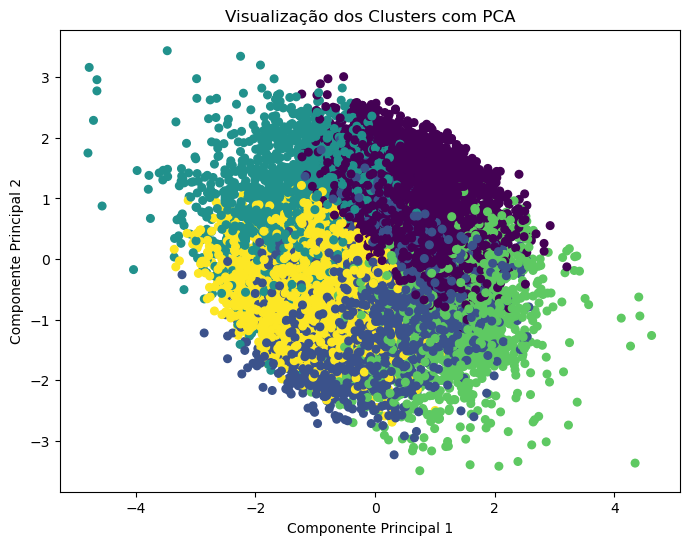

In [28]:
# Visualizando os clusters (usando PCA com 2 componentes, por exemplo)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=df1_clean['Cluster'], cmap='viridis', s=30)
plt.title('Visualização dos Clusters com PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

In [29]:
# Verificando a média das features por cluster
print(df1_clean.groupby('Cluster').mean())

            RAJ2000    DEJ2000      pmRA      pmDE     BP-RP       Plx
Cluster                                                               
0        227.072839 -53.465895 -6.553438 -4.406714  1.760806  1.207481
1        225.651532 -54.213113 -8.486114 -4.764256  1.872855  1.213946
2        227.425181 -54.907084 -6.905954 -5.363663  2.305367  1.226406
3        225.872576 -54.034036 -7.190628 -6.066651  1.393040  1.188988
4        224.507586 -54.938448 -6.520213 -4.442513  1.872608  1.222315


In [30]:
# Identificando outliers para cada cluster (exemplo: usando 1.5 vezes o IQR)
for cluster in df1_clean['Cluster'].unique():
    cluster_data = df1_clean[df1_clean['Cluster'] == cluster]
    Q1 = cluster_data.quantile(0.25)
    Q3 = cluster_data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = cluster_data[(cluster_data < (Q1 - 1.5 * IQR)) | (cluster_data > (Q3 + 1.5 * IQR))]
    print(f"Outliers no Cluster {cluster}:")
    print(outliers)

Outliers no Cluster 2:
       RAJ2000    DEJ2000  pmRA  pmDE  BP-RP  Plx  Cluster
1          NaN        NaN   NaN   NaN    NaN  NaN      NaN
2          NaN        NaN   NaN   NaN    NaN  NaN      NaN
3          NaN        NaN   NaN   NaN    NaN  NaN      NaN
4          NaN        NaN   NaN   NaN    NaN  NaN      NaN
5          NaN        NaN   NaN   NaN    NaN  NaN      NaN
...        ...        ...   ...   ...    ...  ...      ...
15683      NaN -52.716035   NaN   NaN    NaN  NaN      NaN
15785      NaN        NaN   NaN   NaN    NaN  NaN      NaN
16066      NaN -52.429649   NaN   NaN    NaN  NaN      NaN
16117      NaN        NaN   NaN   NaN    NaN  NaN      NaN
16157      NaN        NaN   NaN   NaN    NaN  NaN      NaN

[2501 rows x 7 columns]
Outliers no Cluster 3:
       RAJ2000    DEJ2000  pmRA  pmDE  BP-RP  Plx  Cluster
9          NaN -56.170745   NaN   NaN    NaN  NaN      NaN
71         NaN -56.116648   NaN   NaN    NaN  NaN      NaN
101        NaN        NaN   NaN   NaN    NaN

## Rótulos do Kmeans


In [31]:
from sklearn.model_selection import train_test_split

In [32]:
# Definindo as variáveis: X (features) e y (clusters gerados pelo KMeans)
X = df1_clean.drop(columns=['Cluster'])  # Removendo a coluna de clusters do DataFrame
y = df1_clean['Cluster']  # Rótulos de clusters gerados

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Inicializando o Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Treinando o modelo
rf.fit(X_train, y_train)

# Obtendo a importância das features
feature_importances = pd.DataFrame(rf.feature_importances_, index=X.columns, columns=['Importance']).sort_values('Importance', ascending=False)

# Mostrando as features mais importantes
print(feature_importances)


         Importance
pmRA       0.233679
pmDE       0.189488
RAJ2000    0.187480
DEJ2000    0.180273
BP-RP      0.169589
Plx        0.039491


<Figure size 1000x600 with 0 Axes>

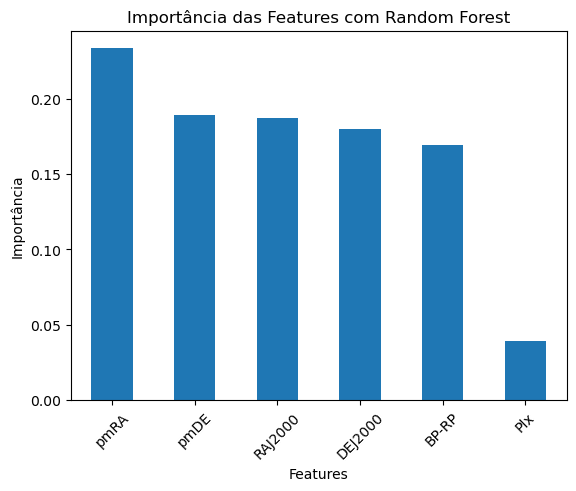

In [33]:
# Criando o gráfico de barras para a importância das features
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar', legend=False)
plt.title('Importância das Features com Random Forest')
plt.xlabel('Features')
plt.ylabel('Importância')
plt.xticks(rotation=45)
plt.show()